<a href="https://colab.research.google.com/github/AbbyNyakara/Mushroom-Classification/blob/dev/STT_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Image Classification Project

# Team:
- Peter Imoukhuede
- Ezequiel Mussambe
- Abigael Mogusu




# PART 1 - Setup and Load data

In [82]:
# Import dependancies:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [83]:
# No gpu connected?? yikes
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [84]:
# Setup GPU memory consumption growth: Avoid the OOM error:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


#### Load the data

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Load data
# The classes of the data depends on the folder name

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Statistics/Project/SmallData',
    batch_size=32
    )

Found 1573 files belonging to 2 classes.


## PART 2. DATA PREPROCESSING:
- Split the data
- Resize the images
- Normalize the Images
- Data Augmentation for edible class to be done on the fly as at the training

In [87]:
# Filter out all images below 20kb:

dataset_dir = '/content/drive/MyDrive/Statistics/Project/SmallData'

def dataset_filtered_by_size(directory, min_size_kb):
    min_size_bytes = min_size_kb * 1024

    # Initialize lists for file paths and labels
    image_paths = []
    labels = []

    # Walk through the directory structure
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            if os.path.getsize(img_path) >= min_size_bytes:  # Filter by file size
                image_paths.append(img_path)
                labels.append(class_name)
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Statistics/Project/SmallData',
    batch_size=32
    )
    # Create TensorFlow dataset from the list of image paths and labels

min_size_kb = 20
dataset_dir = '/content/drive/MyDrive/Statistics/Project/SmallData'
dataset1 = dataset_filtered_by_size(dataset_dir, min_size_kb)

# Dataset 1 - does not contain any images below 20 kb:
dataset1



Found 1573 files belonging to 2 classes.


In [88]:
# Ideally this should be dataset 2:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)
# so that there is no overflow:
validation_size = dataset_size - train_size - test_size

assert train_size + test_size + validation_size == dataset_size

In [89]:
# Now split the data:

# Take and  skip will load the data without loading the entire dataset into memory:
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)
val_ds = dataset.skip(train_size+test_size).take(validation_size)


In [90]:
# The number of batches for the training, test and validation splits:

print(train_ds.cardinality().numpy())
print(test_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())

35
7
8


In [91]:

# Print the classNames:
class_names = dataset.class_names
print(class_names)

# Edible mushrooms - assigns 1
# Inedible mushrooms - Assigned 0

['0 - Inedible Mushrooms', '1. Edible Mushrooms']


In [92]:
# 1. Resize the images:

size = (256, 256)

# Use a labda function to resize all the images for both the training and validatioon sets:
train_ds1 = train_ds.map(lambda image, label:(tf.image.resize(image, size), label))
validation_ds1 = val_ds.map(lambda image, label:(tf.image.resize(image, size), label))

In [57]:
# Normalize the images to a common value:
train_ds = train_ds1.map(lambda image, label: (image/255.0, label))
validation_ds = validation_ds1.map(lambda image, label: (image/255.0, label))


# 3. Exploratory Data Analysis (EDA)

- Check for any outliers in the images
- Display a few random images
- Imbalances in the data:

## 3.1 Display the images:

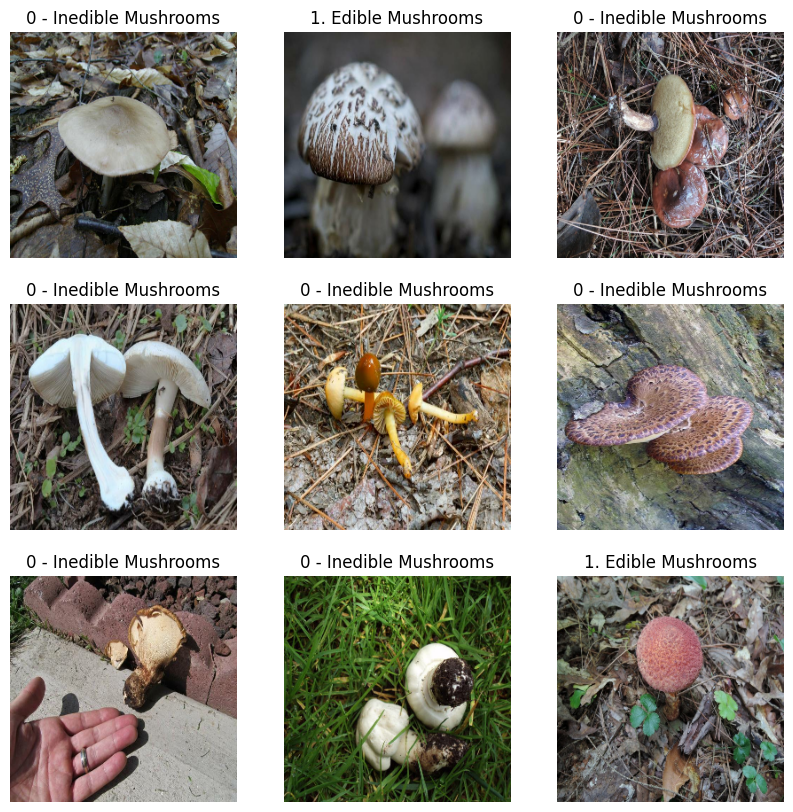

In [93]:
# Display original images :

# The dataset is very highly imbalanced. Only picking the inedbile images??
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 3.2 Check for outliers

In [ ]:

pixel_sums = 0
pixel_sums_squared = 0
num_samples = 0

# Iterate over unbatched dataset to calculate mean and std
for images, _ in train_ds.unbatch():
  pixel_sums += tf.reduce_sum(images, axis=[0, 1, 2])
  pixel_sums_squared += tf.reduce_sum(tf.square(images), axis=[0, 1, 2])
  num_samples += images.shape[0]

# Calculate mean and standard deviation
mean = pixel_sums / num_samples
std = tf.sqrt((pixel_sums_squared / num_samples) - tf.square(mean))

# Define a function to detect outliers
def is_outlier(image, mean, std, threshold=3):
    distance_from_mean = tf.abs(image - mean)
    return tf.reduce_any(distance_from_mean > (threshold * std))

# Collect outliers
outliers = [(image, label) for image, label in train_ds.unbatch() if is_outlier(image, mean, std)]

# Print the number of outliers
print(f"Number of outlier images: {len(outliers)}")

# Visualize outliers
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(outliers[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")
plt.show()


Number of outlier images: 0


<Figure size 1000x1000 with 0 Axes>

## Data augmentation process
- To increase the number of the edible class images (class 1)

In [61]:
# data_gen_minority = ImageDataGenerator(
#     rotation_range=40,       # Random rotations between 0-40 degrees
#     width_shift_range=0.2,   # Random horizontal shifts within 20% of the image width
#     height_shift_range=0.2,  # Random vertical shifts within 20% of the image height
#     shear_range=0.2,         # Shear Intensity (Shear angle in counter-clockwise direction as radians)
#     zoom_range=0.2,          # Random zoom within 20% of the image
#     horizontal_flip=True,    # Random horizontal flips
#     fill_mode='nearest'      # Strategy to fill newly created pixels, which can appear after a rotation or a shift
# )
# # The edible class is in the minority:
# minority_class_dataset = train_ds.filter(lambda image, label: label == 1)

# # The inedible class is in the majority:
# majority_class_dataset = train_ds.filter(lambda image, label: label == 0)

# augmented_minority_class_dataset = minority_class_dataset.map(lambda image, label: (data_gen_minority.random_transform(image), label))

# # Combine majority and augmented minority datasets
# balanced_dataset = majority_class_dataset.concatenate(augmented_minority_class_dataset)

# # Shuffle and batch the dataset
# balanced_dataset = balanced_dataset.shuffle(buffer_size=1000).batch(32)

# # Now you can train your model with this balanced dataset
# # model.fit(balanced_dataset, ...)


## 3.3 Checking for imbalances in the data:

In [ ]:
# Check number of images in each class/ imbalances in the data:

class_counts = {}
for images, labels in dataset:
  for label in labels:
    class_name = class_names[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

for class_name, count in class_counts.items():
  print(f"Class: {class_name}, Count: {count}")

Class: Inedible Mushrooms, Count: 1315
Class: Edible Mushrooms, Count: 258


## Apply data Augmentation:
- Create the data augmentation object:

In [98]:
# Create the data augmentation object to be used in the model building process:

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])


# 4. Convolutional Neural Network Model:

## 4.1 Build the deep learning model

In [ ]:
# Define the model:
model = Sequential()

In [134]:
# Add the layers:
data_augmentation
model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation="relu" ))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation="relu" ))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [135]:
# Compile the model:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [136]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 16)       

## 4.2 Train the model:

In [137]:
log_directory = '/content/drive/MyDrive/Statistics/Project/logs'

In [138]:
# This is to log the model as it trains: (To check how it performs as it trains)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory)

### Save the training history

In [139]:
hist = model.fit(train_ds, epochs=20, validation_data = val_ds, callbacks=tensorboard_callback)

Epoch 1/20
35/35 [==============================] - 6s 128ms/step - loss: 16.0130 - accuracy: 0.7777 - val_loss: 0.6098 - val_accuracy: 0.8297
Epoch 2/20
35/35 [==============================] - 5s 136ms/step - loss: 0.5562 - accuracy: 0.8232 - val_loss: 0.4612 - val_accuracy: 0.8777
Epoch 3/20
35/35 [==============================] - 5s 134ms/step - loss: 0.4828 - accuracy: 0.8286 - val_loss: 0.4646 - val_accuracy: 0.8646
Epoch 4/20
35/35 [==============================] - 5s 138ms/step - loss: 0.3870 - accuracy: 0.8357 - val_loss: 0.4444 - val_accuracy: 0.8734
Epoch 5/20
35/35 [==============================] - 5s 129ms/step - loss: 0.3193 - accuracy: 0.8795 - val_loss: 0.3361 - val_accuracy: 0.8952
Epoch 6/20
35/35 [==============================] - 5s 135ms/step - loss: 0.2374 - accuracy: 0.9170 - val_loss: 0.4778 - val_accuracy: 0.8821
Epoch 7/20
35/35 [==============================] - 5s 142ms/step - loss: 0.1840 - accuracy: 0.9429 - val_loss: 0.4912 - val_accuracy: 0.8865
Epoch

## Plot the perfomance:

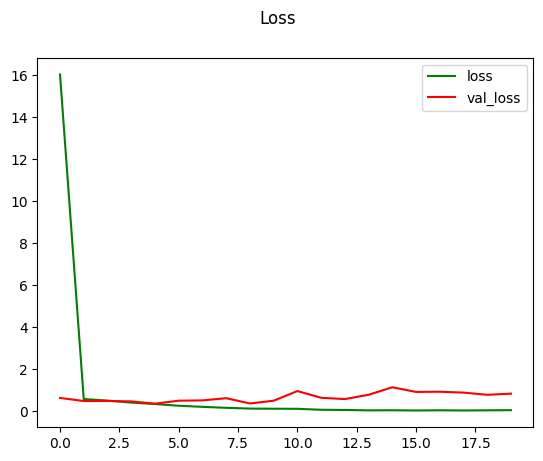

In [140]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='green', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

- The model is pretty awful!!
- Nte: The loss should be a steady decrease: Not what we are seeing!!

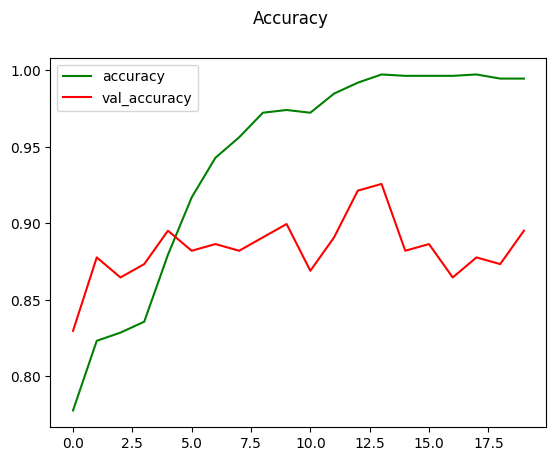

In [141]:
# Plot the accuracy:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
plt.suptitle('Accuracy')
plt.legend()
plt.show()



# 4. Evaluate the Perfomance:

## 4.1 Evaluate the precision, accuracy and the Binary accuracy: (Highest 1, lowest =0)

In [142]:
# Precision, recalla nd binary accuracy:

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
binary_accuracy = tf.keras.metrics.BinaryAccuracy()

In [143]:
for batch in test_ds:
  images, labels = batch
  predictions = model.predict(images)
  precision.update_state(labels, predictions)
  recall.update_state(labels, predictions)
  binary_accuracy.update_state(labels, predictions)

1/1 [==============================] - 0s 33ms/step


In [144]:
# Precision, accuracy and binary accuracy:
print(precision.result().numpy(), recall.result().numpy(), binary_accuracy.result().numpy())

0.8484849 0.6666667 0.9151786


## 4.2 Evaluate the model on a new unseen images:

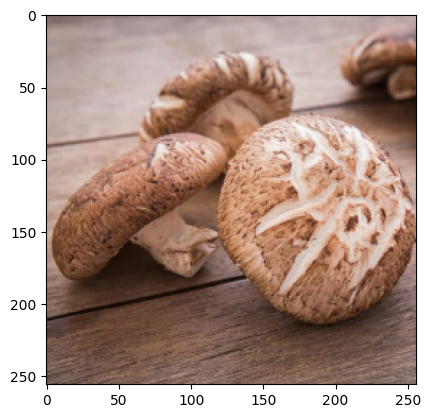

In [145]:
# Import an edible image downloaded from the internet:

img2 = cv2.imread('/content/drive/MyDrive/Statistics/Project/ediblemushroom_test.jpg')
# import the image in its original form:
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (256, 256))
plt.imshow(img2)
plt.show()

In [146]:
np.expand_dims(img2, axis=0).shape

(1, 256, 256, 3)

In [147]:
# The image is of an edible mushroon

y_pred = model.predict(np.expand_dims(img2/255, axis=0))
y_pred

1/1 [==============================] - 0s 71ms/step


array([[0.18798973]], dtype=float32)

# Rename the edible to 1 and inedible to 0
- TODO!

# 5. SAVE THE MODEL:

## 5.1 Test the used model:

In [148]:
model.save('/content/drive/MyDrive/Statistics/Project/mushroomModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [149]:
SavedModel = '/content/drive/MyDrive/Statistics/Project/SavedModel'
model.save(os.path.join(SavedModel, "mushroomModel.h5"))

In [150]:
# Load the saved model and try to use it again??
model_path = os.path.join(SavedModel, "mushroomModel.h5")
new_model = tf.keras.models.load_model(model_path)

In [151]:
# The model is saved and can be used..
new_model.predict(np.expand_dims(img2/255, axis=0))

1/1 [==============================] - 0s 87ms/step


array([[0.18798973]], dtype=float32)